In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

!pip install contractions
import contractions

     |████████████████████████████████| 321 kB 12.2 MB/s 
     |████████████████████████████████| 284 kB 46.6 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85445 sha256=b59a17293e050062b0baa6d694ccb8874efd92116b4f3ef73c3c959811af3f58
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Sarcasm_Headlines_Dataset_v2.json to Sarcasm_Headlines_Dataset_v2.json


Chargement du fichier json

In [3]:
import io
df_train= pd.read_json(io.BytesIO(uploaded['Sarcasm_Headlines_Dataset_v2.json']),lines=True)

In [4]:
df_train.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [5]:
df_train["len"]= df_train["headline"].apply(lambda x : len(x))

In [6]:
np.percentile(df_train["len"],[25,50,75])

array([49., 62., 75.])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


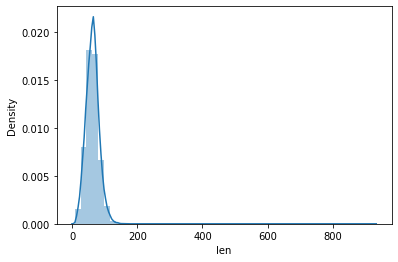

In [7]:
sns.distplot(df_train["len"])

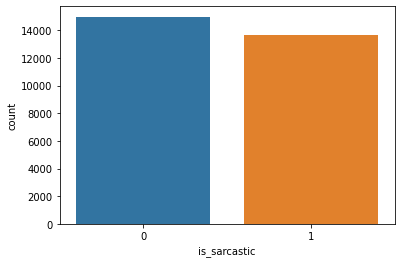

In [8]:
sns.countplot(x="is_sarcastic",data=df_train)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


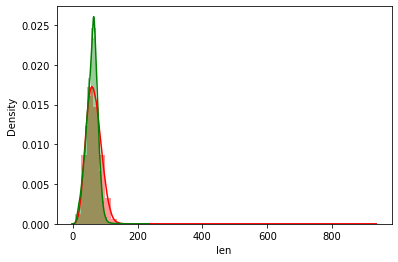

In [9]:
import matplotlib.pyplot as plt
sns.distplot(df_train[df_train['is_sarcastic']==1]["len"],color="red")
sns.distplot(df_train[df_train['is_sarcastic']==0]["len"],color="green")

plt.show()

Prétraitement

In [12]:
!pip install transformers
from transformers import BertTokenizer, TFBertModel, BertConfig,TFBertForSequenceClassification


     |████████████████████████████████| 3.1 MB 12.0 MB/s 
     |████████████████████████████████| 895 kB 69.2 MB/s 
     |████████████████████████████████| 596 kB 64.5 MB/s 
     |████████████████████████████████| 3.3 MB 61.6 MB/s 
     |████████████████████████████████| 59 kB 5.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_train["headline"],df_train["is_sarcastic"], test_size = 0.20, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(22895,) (22895,)
(5724,) (5724,)


In [16]:
train_input = bert_encode(X_train, tokenizer, max_len=100)
test_input = bert_encode(X_test, tokenizer, max_len=100)

In [37]:
import tensorflow_hub as hub 
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

Modélisation

In [38]:
from tensorflow import keras

def build_model(bert_layer, max_len=512):
    input_word_ids = keras.Input(shape=(max_len,), dtype="int32", name="input_word_ids")
    input_mask = keras.Input(shape=(max_len,), dtype="int32", name="input_mask")
    segment_ids = keras.Input(shape=(max_len,), dtype="int32", name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = keras.layers.Dense(64, activation='relu')(clf_output)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(32, activation='relu')(net)
    net = keras.layers.Dropout(0.5)(net)
    out = keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [39]:
model = build_model(bert_layer, 100)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 100, 768)]                'input_mask[0][0]',       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

train_history = model.fit(train_input, y_train, validation_split=0.1,epochs=3,callbacks=[earlystopping],batch_size=32,verbose=1)

Epoch 1/3
644/644 [==============================] - 268s 394ms/step - loss: 0.4315 - accuracy: 0.7979 - val_loss: 0.2267 - val_accuracy: 0.9074
Epoch 2/3
644/644 [==============================] - 253s 393ms/step - loss: 0.2506 - accuracy: 0.9040 - val_loss: 0.2022 - val_accuracy: 0.9192
Epoch 3/3
644/644 [==============================] - 253s 393ms/step - loss: 0.1778 - accuracy: 0.9355 - val_loss: 0.2293 - val_accuracy: 0.9135


Evaluation

In [41]:
model.evaluate(test_input,y_test)

179/179 [==============================] - 23s 130ms/step - loss: 0.2216 - accuracy: 0.9196


[0.22157210111618042, 0.919636607170105]